In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask/Validation/WithoutMask/1017.png
/kaggle/input/face-mask/Validation/WithoutMask/4803.png
/kaggle/input/face-mask/Validation/WithoutMask/5106.png
/kaggle/input/face-mask/Validation/WithoutMask/3765.png
/kaggle/input/face-mask/Validation/WithoutMask/780.png
/kaggle/input/face-mask/Validation/WithoutMask/3952.png
/kaggle/input/face-mask/Validation/WithoutMask/227.png
/kaggle/input/face-mask/Validation/WithoutMask/2731.png
/kaggle/input/face-mask/Validation/WithoutMask/579.png
/kaggle/input/face-mask/Validation/WithoutMask/353.png
/kaggle/input/face-mask/Validation/WithoutMask/2645.png
/kaggle/input/face-mask/Validation/WithoutMask/3375.png
/kaggle/input/face-mask/Validation/WithoutMask/1995.png
/kaggle/input/face-mask/Validation/WithoutMask/5674.png
/kaggle/input/face-mask/Validation/WithoutMask/1604.png
/kaggle/input/face-mask/Validation/WithoutMask/2522.png
/kaggle/input/face-mask/Validation/WithoutMask/232.png
/kaggle/input/face-mask/Validation/WithoutMask/5503.p

# **`Import Dependencies `**

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG19
from tensorflow.keras import optimizers


# **`Setting Directories and Reading Images `**

In [4]:
train_dir = "/kaggle/input/face-mask/Train"
validation_dir = "/kaggle/input/face-mask/Validation"
test_dir ="/kaggle/input/face-mask/Test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# `Create a convolution base using (InceptionV3)GoogLeNet`

In [6]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

2022-02-27 16:33:41.252644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 16:33:41.348606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 16:33:41.349310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 16:33:41.350557: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


# **`Create a CNN model by adding a Fully Connected Classifier `**

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


# **`Compile the Model`**

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

# **`Setting Checkpoints and Training `**

In [10]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only =True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=500,
      epochs=150,
      validation_data=validation_generator,
      validation_steps=40,
      callbacks=[checkpoint_cb, early_stopping_cb])

2022-02-27 16:33:44.948632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-02-27 16:33:47.506086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


500/500 [==============================] - 101s 184ms/step - loss: 0.0694 - acc: 0.9755 - val_loss: 5.9688e-04 - val_acc: 1.0000
Epoch 2/150
500/500 [==============================] - 70s 141ms/step - loss: 0.0275 - acc: 0.9924 - val_loss: 0.0043 - val_acc: 0.9975
Epoch 3/150
500/500 [==============================] - 70s 141ms/step - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0047 - val_acc: 0.9987
Epoch 4/150
500/500 [==============================] - 71s 142ms/step - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0441 - val_acc: 0.9875
Epoch 5/150
500/500 [==============================] - 71s 141ms/step - loss: 0.0202 - acc: 0.9948 - val_loss: 0.0355 - val_acc: 0.9962
Epoch 6/150
500/500 [==============================] - 70s 140ms/step - loss: 0.0171 - acc: 0.9963 - val_loss: 6.4854e-05 - val_acc: 1.0000
Epoch 7/150
500/500 [==============================] - 70s 141ms/step - loss: 0.0167 - acc: 0.9967 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 8/150
500/500 [==============================

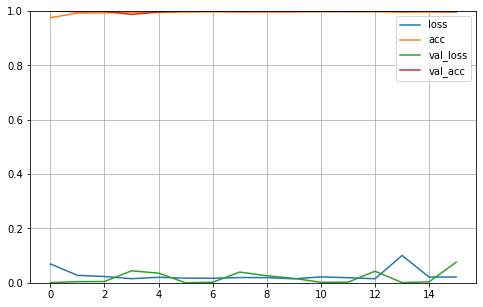

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [13]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128,128),
        batch_size=20,
        class_mode='binary')

Found 992 images belonging to 2 classes.


In [16]:
model.evaluate(test_generator, steps=49)

49/49 [==============================] - 3s 51ms/step - loss: 5.9828e-04 - acc: 1.0000


[0.00059828459052369, 1.0]